### Using facebook prophet, I'm interested in trying to predict the volume of different citations over time.

my inspiration for this https://pbpython.com/prophet-overview.html

### Import and Prep data

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\mrkjh\Miniconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
citations = pd.read_csv('data/citations.csv ', 
                        index_col='Citation #',
                       low_memory=False)

In [4]:
citations.shape

(60718, 21)

In [5]:
citations.head()

,Arizona Statute Code,Beat,Charge Description,Citation Date,Citation Time,Citation Type Code,Citation Type Description,Cited Person,Cited Person Age,Cited Person Ethnicity,...,Cited Person Sex,City,District,Officer Badge #,State,Street,Street Number,Zip,Zone,tcmainid
Citation #,,,,,,,,,,,,,,,,,,,,,
2074492,97XX,12.0,Amended Charge,12/20/2018,2222,CV,Civil Traffic,"Way, Dennis",51,U,...,M,Scottsdale,D3,1476,AZ,E Sahuaro DR / N Scottsdale Rd,xxx,NaN,3003.0,641301
8093305,28-701A,10.0,Speed Greater Than R&P or Posted,12/20/2018,844,CV,Civil Traffic,"Grady, Scott",61,U,...,M,Scottsdale,D3,780,AZ,N Scottsdale Rd,8xxx,NaN,2601.0,641302
2076259,28-4135C,3.0,No Proof of Insurance,12/18/2018,2147,CV,Civil Traffic,"Dudgeon, Miranda",20,U,...,F,Scottsdale,D1,1509,AZ,E Osborn Rd / N Scottsdale Rd,xxx,NaN,706.0,641303
8093703,28-2532A,5.0,Expired/No Arizona Registration,12/21/2018,2116,CV,Civil Traffic,"Fox, William",34,U,...,M,Scottsdale,D2,826,AZ,E Chaparral Rd / N Hayden Rd,xxx,NaN,1106.0,641304
2053182,28-4135C,15.0,No Proof of Insurance,12/20/2018,2324,CV,Civil Traffic,"Rhoden, David",24,U,...,M,Scottsdale,D4,1440,AZ,E Frank Lloyd Wright Bl / N Hayden Rd,xxx,NaN,3604.0,641305


In [6]:
citations.loc[:,'Citation Date'] = pd.to_datetime(citations['Citation Date'])

In [7]:
citations['Citation Date'].min()

Timestamp('2017-09-23 00:00:00')

In [8]:
citations['Citation Date'].max()

Timestamp('2020-04-23 00:00:00')

In [19]:
# aggregate based on count per day
count_per_day = citations.groupby('Citation Date').size().reset_index()

In [21]:
# assign labels to colmns
# based on what Prophet requires
count_per_day.columns = ["ds", "y"]

In [22]:
count_per_day

,ds,y
0,2017-09-23,32
1,2017-09-24,75
2,2017-09-25,90
3,2017-09-26,80
4,2017-09-27,106
...,...,...
939,2020-04-19,3
940,2020-04-20,13
941,2020-04-21,25
942,2020-04-22,19


### Model using Prophet

In [23]:
m1 = Prophet()
m1.fit(count_per_day)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


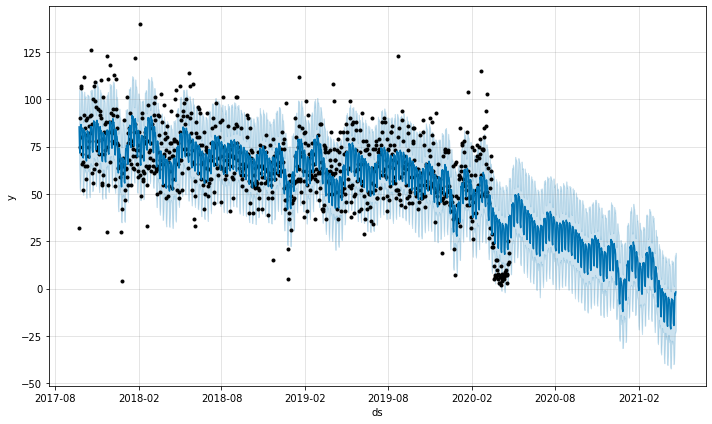

In [24]:
# predict 1 year into the future
future1 = m1.make_future_dataframe(periods=365)

# make forecast
forecast1 = m1.predict(future1)

# plot forecast
m1.plot(forecast1);

Clearly covid-19 has dramatically reduced citation counts, which is causing the model to predict a downward trend for the future.